In [143]:
# most stuff in this nb will be moved to either config or hospital_model.

import random
import numpy as np
import simpy

# todo: config to be defined in config.py
configuration_default_mkB = {
    'seed': None,
    'means': [25, 40, 20, 40], # mean times of all stages: next/prep/op/rec
    'rooms': [3, 1, 3], # totals of each identical facility: prep/op/rec
    'monitor_interval': 20 # snapshot interval for non-patient variables, such as queues
}

In [144]:
# generator starts new patient process according to interval distribution
def patient_generator_mkB(env,conf,resu,facilities):
    while True:
        env.process(patient_mkB(env,conf,resu,facilities))
        yield env.timeout(random.expovariate(1/conf['means'][0]))

In [145]:
# individual patient, keeps track of actual service times for each stage: required time and extra waiting
def patient_mkB(env,conf,resu,facilities):
    # minimum processing times for each stage, using config
    e = random.expovariate
    req_times = [e(1/conf['means'][1]),e(1/conf['means'][2]),e(1/conf['means'][3])]

    flow_times = [env.now, 0, 0, 0, 0] # arrival times at each stage, including release
    resu['patient_flow'].append(flow_times)
    
    # --- individual patient path through system ---
    # note that patient path logging is also timed, to reduce error in total
    # * if it was logged at the end, active patients would not affect simulation results
    # * some error still remains, from not considering partial process completions at result calculation moment.

    prep = facilities[0].request()
    resu['patient_counts'][0] += 1
    yield prep # wait prep room
    flow_times[1] = env.now # patient taken to a prep room
    resu['patient_counts'][1] += 1
    
    yield env.timeout(req_times[0])
    op = facilities[1].request()
    resu['util_active'][0] += req_times[0] # prep done, waiting op
    yield op
    facilities[0].release(prep) # op room free, release prep
    resu['patient_counts'][1] -= 1
    resu['patient_counts'][2] += 1
    flow_times[2] = env.now # patient enters operation
    resu['total_active'][0] += flow_times[2] - flow_times[1] # op start - prep start = prep total
    
    yield env.timeout(req_times[1])
    rec = facilities[2].request()
    
    resu['util_active'][1] += req_times[1] # op done
    yield rec
    facilities[1].release(op) # op free once rec opens
    resu['patient_counts'][2] -= 1
    resu['patient_counts'][3] += 1
    flow_times[3] = env.now # patient starts recovery
    resu['total_active'][1] += flow_times[3] - flow_times[2] # op total

    yield env.timeout(req_times[2])
    facilities[2].release(rec) # rec done
    resu['patient_counts'][3] -= 1
    resu['patient_counts'][0] -= 1 # reduce total # of patients in system when rec is done
    resu['util_active'][2] += req_times[2] # rec done
    resu['total_active'][2] += req_times[2] # rec does not need to wait, so util% is always 100.
    flow_times[4] = env.now # patient leaves

In [146]:
def monitor_mkB(env,conf,resu,facilities):
    while True:
        snapshot = {
            'time': env.now,
            'patient_counts': resu['patient_counts'].copy() # totals in system at snapshot time
        }
        resu['snapshots'].append(snapshot)
        yield env.timeout(conf['monitor_interval'])

In [147]:
def create_hospital_simulation(env,conf):
    # simulation results
    resu = {
        'patient_flow': [], # all flow times for each patient: arrival/prep/op/rec/leave
        'patient_counts': [0,0,0,0], # patient count in: total/prep/op/rec
        'total_active': [0,0,0], # total time of prep/op/rec
        'util_active': [0,0,0], # active time of prep/op/rec
        'snapshots': [] # simulation situation at snapshot times, created by monitor process
    }
    # seed the rng
    random.seed(a=conf['seed']) # doesnt need to check for None, seed() already does
    # create limited resources
    facilities = [
        simpy.Resource(env,capacity=conf['rooms'][0]),
        simpy.Resource(env,capacity=conf['rooms'][1]),
        simpy.Resource(env,capacity=conf['rooms'][2])
    ]
    # create always-on processes
    env.process(monitor_mkB(env,conf,resu,facilities))
    env.process(patient_generator_mkB(env,conf,resu,facilities))
    return resu

In [152]:
env = simpy.Environment()

conf = configuration_default_mkB.copy() # prevent side effect on default configuration
conf['seed'] = 2025
results = create_hospital_simulation(env,conf)
env.run(until=2000)
print(results['util_active'][1] / results['total_active'][1]) # op room utilization %
# (note /0 error if sim time is too short to have any events. this is fine.)
print(results['patient_flow'][0]) # first patient entire treatment timeline
print(results['patient_counts'])
print(results['snapshots'][-1]['patient_counts'])

# simulate changing hospital flow.
# note that this can also take into account the current simulation state.
# for demonstration this just makes a visible change by reducing amount of new patients entering the system
conf['means'] = [100, 40, 20, 40]
env.run(until=env.now + 2000)
print(results['snapshots'][-1])

1.0000000000000004
[0, 0, 51.90383750379573, 64.89050943476566, 66.79345859258284]
[3, 2, 1, 0]
[3, 3, 0, 0]
{'time': 3980, 'patient_counts': [0, 0, 0, 0]}


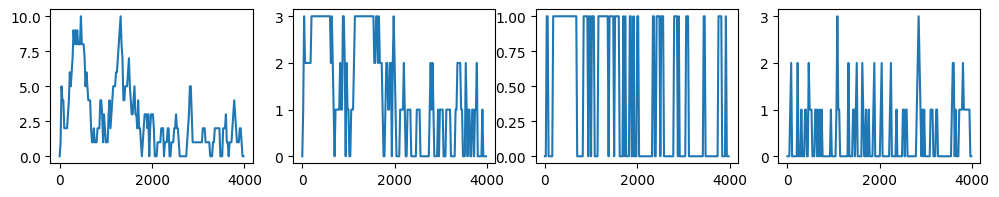

In [154]:
# visualize rooms:
import matplotlib.pyplot as plt

plot_stages = len(results['snapshots'][0]['patient_counts']) # plot each metric monitored by snapshots
fig, axs = plt.subplots(figsize=(3*plot_stages,2),ncols = plot_stages)
x = [s['time'] for s in results['snapshots']] # snapshot times on x-axis
for a in range(len(axs)):
    axs[a].plot(x,[s['patient_counts'][a] for s in results['snapshots']])